In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#from Shape_Visualisation import draw_shape
%matplotlib inline

In [2]:
df=pd.read_csv("urop.csv")


# extract healthy echo data
df = df.drop(["IDshort",'SERNO','HistoCode'], 1)
mask=df["Cardiac_Category (0=good; 1=poor)"]==0
healthy_df=df[mask]
echo=healthy_df.iloc[:,19:55]

# fill in missing data
for col in echo.columns:
    echo[col].fillna(echo[col].mean(),inplace=True)

    
# data that form part of cardiac geometry    
left_ventricle=echo.iloc[:,1:8]
aorta=echo.iloc[:,8:9]
left_atrium=echo.iloc[:,9:10]
sinus=echo.iloc[:,-4:-2]

In [3]:
# Step 1 : Standardize/normalise the data

from sklearn.preprocessing import StandardScaler

In [5]:
norm_lv=StandardScaler().fit_transform(left_ventricle)

In [6]:
# Check if data is normalized

np.mean(norm_lv) , np.std(norm_lv)

(-5.014884954769414e-16, 1.0)

In [7]:
# Visualisation of standardized data

lv_df=pd.DataFrame(norm_lv,columns=left_ventricle.columns)
lv_df.head(3)

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm,LVOT__cm
0,-0.674031,-1.301265,-0.641467,0.520507,-1.043695,-1.148882,-0.065609
1,1.899542,1.506259,2.934855,3.127819,2.881844,0.994111,0.651986
2,-0.674031,0.102497,-0.130564,-0.081180,0.264818,-0.434551,-0.266535


In [9]:
from sklearn.decomposition import PCA
from math import pi

In [10]:
# Apply PCA on normalised dataset


class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        if self.no_of_components is None:
            self.no_of_components = x.shape[1]
        else:
            self.no_of_components = self.no_of_components
            
            
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]
        self.explained_variance = self.eigen_values[self.sorted_components[:self.no_of_components]]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

In [10]:
# Check how many components are required to retain 98% variance

pca=PCA(0.98)
pca_lv=pca.fit_transform(norm_lv)
pca.n_components_

6

In [11]:
# Create PCA with 6 components
pca=convers_pca(no_of_components=6)
pca.fit(norm_lv)

In [7]:
# x = x_m + Pb
# x_m --> mean 
# P   --> t eigenvectors (p1|p2|....|pt)
# b   --> t vectors of weights (b1|b2|....|bt)T ,  -3 sqrt(lambda) < b_i < 3 sqrt(lambda)

x_m=np.array(left_ventricle.mean())


In [13]:
p=pca.projection_matrix.T

In [14]:
b=pca.explained_variance_ratio
lower_limit=-2*np.sqrt(b)
upper_limit=2*np.sqrt(b)

In [15]:
#adjust 1st mode, set all other paramters to zero

b1_low=np.concatenate((lower_limit[0],np.zeros(5)),axis=None).T
b1_high=np.concatenate((upper_limit[0],np.zeros(5)),axis=None).T
b2_low=np.concatenate((np.zeros(1),lower_limit[1],np.zeros(4)),axis=None).T
b2_high=np.concatenate((np.zeros(1),upper_limit[1],np.zeros(4)),axis=None).T

In [16]:
x1_low=x_m+ np.matmul(p,b1_low)
x1_high=x_m+ np.matmul(p,b1_high)
x2_low=x_m+ np.matmul(p,b2_low)
x2_high=x_m+ np.matmul(p,b2_high)

In [17]:
x1_low,x_m,x1_high

(array([1.31605508, 1.65304313, 4.94685027, 2.82398866, 1.29871838,
        1.9353307 , 2.47093863]),
 array([0.77857143, 1.17809524, 4.37666667, 2.44047619, 0.75952381,
        1.42166667, 2.02285714]),
 array([0.24108778, 0.70314734, 3.80648306, 2.05696372, 0.22032924,
        0.90800263, 1.57477565]))

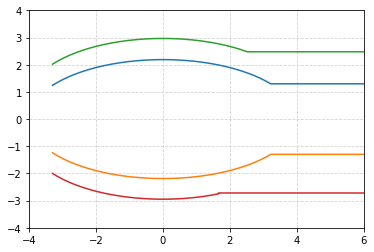

In [132]:
# use draw_shape() method on x1_low,x_m,x1_high

draw_shape(x_m)

In [131]:
# DON'T TOUCH (compare wif active shape model 1)
def draw_shape(a):


    septum_d,septum_s=a[0],a[1]
    dim_d,dim_s=a[2],a[3]
    wall_d,wall_s=a[4],a[5]


    # Estimate shape using  parametric eqn of ellipse
    # x = u + a cos(t) ; y = v + b sin(t)

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=4 #radius on the x-axis
    b=dim_d/2   #radius on the y-axis
    indices=[]

    t_all= np.linspace(0, 2*pi, 100)
    x_all=(u+a*np.cos(t_all))[::-1]
    y_all=(v+b*np.sin(t_all))[::-1]

    
    #remove x,y coordinates where y< (dim_s/2)

    for i,(x,y) in enumerate(zip(x_all,y_all)):
        if y<=dim_s/2:
            indices+=[i]


    x=np.delete(x_all,indices)
    y=np.delete(y_all,indices)
    
    y_s=y + septum_d
    y_w= -y - wall_d
    
    
    
    # Split the ellipse into 2 (left and right)

    ys_left=y_s[:np.argmax(y_s)+1]
    xs_left=x[:np.argmax(y_s)+1]
    yw_left=y_w[:np.argmin(y_w)+1]
    xw_left=xs_left

    ys_right=y_s[np.argmax(y_s):]
    xs_right=x[np.argmax(y_s):]
    yw_right=y_w[np.argmin(y_w):]
    xw_right=xs_right
    
    # Ensure that the right side of the ellipse do not go under the straight line

    indices=np.where(ys_right< (y[-1]+ septum_s))
    indices_1=np.where(yw_right > (-y[-1]-wall_s))

    ys_right = np.delete(ys_right, indices)
    xs_right= np.delete(xs_right, indices)
    yw_right=np.delete(yw_right,indices_1)
    xw_right=np.delete(xw_right,indices_1)
    
    
    # Estimate shape of LVIDs using a horizontal line
    
    x_more=np.linspace(x[-1],6,100)
    y_more=np.linspace(y[-1],y[-1],100)
    ys_more=np.linspace(y[-1]+ septum_s,y[-1] + septum_s,100)
    yw_more=np.linspace(-y[-1]-wall_s,-y[-1] - wall_s,100)
    xs_more=np.linspace(xs_right[-1],6,100)
    xw_more=np.linspace(xw_right[-1],6,100)
    
    
    # Add all the x,y coordinates respectively

    x=np.concatenate((x,x_more),axis=None)
    y=np.concatenate((y,y_more),axis=None)
    y_s=np.concatenate((ys_left,ys_right,ys_more),axis=None)
    x_s=np.concatenate((xs_left,xs_right,xs_more),axis=None)
    y_w=np.concatenate((yw_left,yw_right,yw_more),axis=None)
    x_w=np.concatenate((xw_left,xw_right,xw_more),axis=None)
    
    # Plot the graphs

    
    plt.grid(color='lightgray',linestyle='--')
    plt.xlim(-4, 6)
    plt.ylim(-4, 4)
    plt.plot(x,y)
    plt.plot(x,-y)
    plt.plot(x_s,y_s)
    plt.plot(x_w,y_w)
    plt.show()
    
    #return x,y

In [57]:
X=x.copy()
Y=y.copy()

In [65]:

XY=np.array([])
for i in range(len(X)):
    xy=np.concatenate(([X[i]],[Y[i]]),axis=None)
    XY=np.append(XY,xy)
    
print(XY)

[-3.14421238  1.52896997 -2.9810578   1.64920321 -2.80589955  1.76279568
 -2.61944294  1.86928999 -2.42243875  1.96825734 -2.21568026  2.05929921
 -2.          2.142049   -1.77626645  2.21617352 -1.5453805   2.2813743
 -1.30827185  2.33738878 -1.06589525  2.38399142 -0.81922667  2.42099457
 -0.56925935  2.44824924 -0.31699983  2.46564566 -0.06346386  2.4731138
  0.19032766  2.47062358  0.4433528   2.45818504  0.69459271  2.43584825
  0.94303574  2.40370316  1.1876815   2.36187921  1.42754489  2.3105448
  1.66166005  2.24990664  1.8890843   2.18020891  2.10890187  2.10173224
  2.32022764  2.01479264  2.52221067  1.91974017  2.71403765  1.8169576
  2.89493615  1.70685877  3.06417777  1.58988703  3.22108103  1.46651338
  3.22108103  1.46651338  3.24915092  1.46651338  3.27722081  1.46651338
  3.3052907   1.46651338  3.33336058  1.46651338  3.36143047  1.46651338
  3.38950036  1.46651338  3.41757025  1.46651338  3.44564014  1.46651338
  3.47371003  1.46651338  3.50177992  1.46651338  3.529

In [66]:
len(XY)

260

In [68]:
# XY contains 130 landmark points
XY

array([-3.14421238,  1.52896997, -2.9810578 ,  1.64920321, -2.80589955,
        1.76279568, -2.61944294,  1.86928999, -2.42243875,  1.96825734,
       -2.21568026,  2.05929921, -2.        ,  2.142049  , -1.77626645,
        2.21617352, -1.5453805 ,  2.2813743 , -1.30827185,  2.33738878,
       -1.06589525,  2.38399142, -0.81922667,  2.42099457, -0.56925935,
        2.44824924, -0.31699983,  2.46564566, -0.06346386,  2.4731138 ,
        0.19032766,  2.47062358,  0.4433528 ,  2.45818504,  0.69459271,
        2.43584825,  0.94303574,  2.40370316,  1.1876815 ,  2.36187921,
        1.42754489,  2.3105448 ,  1.66166005,  2.24990664,  1.8890843 ,
        2.18020891,  2.10890187,  2.10173224,  2.32022764,  2.01479264,
        2.52221067,  1.91974017,  2.71403765,  1.8169576 ,  2.89493615,
        1.70685877,  3.06417777,  1.58988703,  3.22108103,  1.46651338,
        3.22108103,  1.46651338,  3.24915092,  1.46651338,  3.27722081,
        1.46651338,  3.3052907 ,  1.46651338,  3.33336058,  1.46

In [71]:
left_ventricle.head(3)

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm,LVOT__cm
3,0.7,0.9,4.0,2.7,0.6,1.1,2.00
7,1.0,1.5,6.1,4.0,1.2,1.7,2.25
12,0.7,1.2,4.3,2.4,0.8,1.3,1.93


In [54]:
def get_ellipse(a):


    septum_d,septum_s=a[0],a[1]
    dim_d,dim_s=a[2],a[3]
    wall_d,wall_s=a[4],a[5]


    # Estimate shape using  parametric eqn of ellipse
    # x = u + a cos(t) ; y = v + b sin(t)

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=4 #radius on the x-axis
    b=dim_d/2   #radius on the y-axis
    indices=[]

    t_all= np.linspace(0, 2*pi, 50)
    x_all=(u+a*np.cos(t_all))[::-1]
    y_all=(v+b*np.sin(t_all))[::-1]
    
    #plt.plot(x_all,y_all)

    
    #remove x,y coordinates where y< (dim_s/2)

    for i,(x,y) in enumerate(zip(x_all,y_all)):
        if y<=dim_s/2:
            indices+=[i]


    x=np.delete(x_all,indices)
    y=np.delete(y_all,indices)
    
    y_s=y + septum_d
    y_w= -y - wall_d
    
    x_more=np.linspace(x[-1],6,10)
    y_more=np.linspace(y[-1],y[-1],10)
    
    # Split the ellipse into 2 (left and right)
    x_left=x[:np.argmax(y)+1]
    y_left=y[:np.argmax(y)+1]
    
    ys_left=y_s[:np.argmax(y_s)+1]
    xs_left=x[:np.argmax(y_s)+1]
    yw_left=y_w[:np.argmin(y_w)+1]
    xw_left=xs_left

    x_right=x[np.argmax(y_s):]
    y_right=y[np.argmax(y_s):]
    
    return x_left,y_left,x_right,y_right
    
    '''x_left=np.linspace(x_left[0],x_left[-1],10,True)
    y_left=np.linspace(y_left[0],y_left[-1],10,True)
    
    x_right=np.linspace(x_right[0],x_right[-1],10,True)
    y_right=np.linspace(y_right[0],y_right[-1],10,True)'''
    
    x=np.concatenate((x_left,x_right,x_more),axis=None)
    y=np.concatenate((y_left,y_right,y_more),axis=None)
    

    
    XY=np.array([])
    for i in range(len(x)):
        xy=np.concatenate(([x[i]],[y[i]]),axis=None)
        XY=np.append(XY,xy)
        
    #print(list_of_lengths)
    plt.plot(x,y)
    
    
    #print(len(x_left),len(x_right)
    
    return XY


    ys_right=y_s[np.argmax(y_s):]
    xs_right=x[np.argmax(y_s):]
    yw_right=y_w[np.argmin(y_w):]
    xw_right=xs_right
    
    # Ensure that the right side of the ellipse do not go under the straight line

    indices=np.where(ys_right< (y[-1]+ septum_s))
    indices_1=np.where(yw_right > (-y[-1]-wall_s))

    ys_right = np.delete(ys_right, indices)
    xs_right= np.delete(xs_right, indices)
    yw_right=np.delete(yw_right,indices_1)
    xw_right=np.delete(xw_right,indices_1)
    
    
    # Estimate shape of LVIDs using a horizontal line
    
    x_more=np.linspace(x[-1],6,50)
    y_more=np.linspace(y[-1],y[-1],50)
    ys_more=np.linspace(y[-1]+ septum_s,y[-1] + septum_s,50)
    yw_more=np.linspace(-y[-1]-wall_s,-y[-1] - wall_s,50)
    xs_more=np.linspace(xs_right[-1],6,50)
    #xw_more=np.linspace(xw_right[-1],6,50)
    
    
    # Add all the x,y coordinates respectively

    #x=np.concatenate((x,x_more),axis=None)
    #y=np.concatenate((y,y_more),axis=None)
    y_s=np.concatenate((ys_left,ys_right,ys_more),axis=None)
    x_s=np.concatenate((xs_left,xs_right,xs_more),axis=None)
    y_w=np.concatenate((yw_left,yw_right,yw_more),axis=None)
    #x_w=np.concatenate((xw_left,xw_right,xw_more),axis=None)
    
    XY=np.array([])
    for i in range(len(x)):
        xy=np.concatenate(([x[i]],[y[i]]),axis=None)
        XY=np.append(XY,xy)
        
    plt.plot(x,y)
    
        
    return XY

In [55]:
def get_length(a):


    septum_d,septum_s=a[0],a[1]
    dim_d,dim_s=a[2],a[3]
    wall_d,wall_s=a[4],a[5]


    # Estimate shape using  parametric eqn of ellipse
    # x = u + a cos(t) ; y = v + b sin(t)

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=4 #radius on the x-axis
    b=dim_d/2   #radius on the y-axis
    indices=[]

    t_all= np.linspace(0, 2*pi, 50)
    x_all=(u+a*np.cos(t_all))[::-1]
    y_all=(v+b*np.sin(t_all))[::-1]
    
    #plt.plot(x_all,y_all)

    
    #remove x,y coordinates where y< (dim_s/2)

    for i,(x,y) in enumerate(zip(x_all,y_all)):
        if y<=dim_s/2:
            indices+=[i]


    x=np.delete(x_all,indices)
    y=np.delete(y_all,indices)
    
    y_s=y + septum_d
    y_w= -y - wall_d
    
    x_more=np.linspace(x[-1],6,10)
    y_more=np.linspace(y[-1],y[-1],10)
    
    # Split the ellipse into 2 (left and right)
    x_left=x[:np.argmax(y)+1]
    y_left=y[:np.argmax(y)+1]
    
    ys_left=y_s[:np.argmax(y_s)+1]
    xs_left=x[:np.argmax(y_s)+1]
    yw_left=y_w[:np.argmin(y_w)+1]
    xw_left=xs_left

    x_right=x[np.argmax(y_s):]
    y_right=y[np.argmax(y_s):]
    
    return len(x_left),len(x_right)
    


In [56]:
# create function that vectorises the points in the same dimension
list_a, list_b= [], []
def get_list(a,b):
    list_a.append(a)
    list_b.append(b)
    
    return a,b,c
for i in range(len(rows_2d)):
    a,b= get_length(rows_2d[i])
    get_list(a,b)
    
list_a,list_b

([7,
  7,
  8,
  9,
  8,
  8,
  8,
  8,
  8,
  8,
  7,
  9,
  9,
  8,
  9,
  8,
  8,
  8,
  9,
  8,
  8,
  9,
  8,
  8,
  9,
  9,
  9,
  7,
  8,
  9,
  8,
  8,
  9,
  8,
  10,
  8,
  9,
  9,
  9,
  9,
  9,
  8],
 [7,
  7,
  8,
  9,
  7,
  8,
  8,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  9,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  7,
  7,
  8,
  9,
  9,
  7,
  7,
  9,
  7,
  8,
  9,
  7,
  9,
  8,
  9,
  9,
  9,
  9,
  8,
  8])

In [97]:

def get_vector(x_left,y_left,x_right,y_right):
    idx_l,idx_r=[],[]
    if len(x_left)>min(list_a):
        idx_l+=range(min(list_a),len(x_left))
    
    if len(x_right)>min(list_b):
        idx_r+=range(min(list_b),len(x_right))
    
    x_left = np.delete(x_left,idx_l,axis=None)
    y_left = np.delete(y_left,idx_l,axis=None)
    
    x_right= np.delete(x_right,idx_r,axis=None)
    y_right= np.delete(y_right,idx_r,axis=None)
    
    x_more=np.linspace(x_right[-1],6,10)
    y_more=np.linspace(y_right[-1],y_right[-1],10)
    
    
    XY_left =np.array([])
    for i in range(len(x_left)):
        xy=np.concatenate(([x_left[i]],[y_left[i]]),axis=None)
        XY_left=np.append(XY_left,xy)
        
        
    XY_right =np.array([])
    for i in range(len(x_left)):
        xy=np.concatenate(([x_right[i]],[y_right[i]]),axis=None)
        XY_right=np.append(XY_right,xy)
        

    XY=np.concatenate((XY_left,XY_right),axis=None)
    
    return XY

In [98]:
a,b,c,d=get_ellipse(x_m)
get_vector(a,b,c,d)

array([-3.04578383,  1.41853981, -2.68920356,  1.61997502, -2.28846664,
        1.79481028, -1.85015316,  1.94017482, -1.38146022,  2.05368173,
       -0.89008374,  2.13346725, -0.3840921 ,  2.17822129,  0.12820631,
        2.187209  ,  0.63839958,  2.1602828 ,  1.13811035,  2.09788482,
        1.61913337,  2.00103962,  2.07357027,  1.87133741,  2.49395921,
        1.71090789,  2.8733974 ,  1.52238531])

In [86]:
get_ellipse(x_m)

(array([-3.04578383, -2.68920356, -2.28846664, -1.85015316, -1.38146022,
        -0.89008374, -0.3840921 ,  0.12820631]),
 array([1.41853981, 1.61997502, 1.79481028, 1.94017482, 2.05368173,
        2.13346725, 2.17822129, 2.187209  ]),
 array([0.12820631, 0.63839958, 1.13811035, 1.61913337, 2.07357027,
        2.49395921, 2.8733974 , 3.20565449]),
 array([2.187209  , 2.1602828 , 2.09788482, 2.00103962, 1.87133741,
        1.71090789, 1.52238531, 1.30886521]))

In [114]:

def get_full_xy(row):

    a,b,c,d=get_ellipse(row)
    XY=get_vector(a,b,c,d)
    x_more=np.linspace(XY[-2],6,10)
    y_more=np.linspace(XY[-1],XY[-1],10)
    XY_more =np.array([])
    for i in range(len(x_more)):
        xy=np.concatenate(([x_more[i]],[y_more[i]]),axis=None)
        XY_more=np.append(XY_more,xy)


    XY=np.concatenate((XY,XY_more))
    
    return XY

In [115]:
get_full_xy(x_m)

array([-3.04578383,  1.41853981, -2.68920356,  1.61997502, -2.28846664,
        1.79481028, -1.85015316,  1.94017482, -1.38146022,  2.05368173,
       -0.89008374,  2.13346725, -0.3840921 ,  2.17822129,  0.12820631,
        2.187209  ,  0.63839958,  2.1602828 ,  1.13811035,  2.09788482,
        1.61913337,  2.00103962,  2.07357027,  1.87133741,  2.49395921,
        1.71090789,  2.8733974 ,  1.52238531,  2.8733974 ,  1.52238531,
        3.22079769,  1.52238531,  3.56819798,  1.52238531,  3.91559827,
        1.52238531,  4.26299856,  1.52238531,  4.61039884,  1.52238531,
        4.95779913,  1.52238531,  5.30519942,  1.52238531,  5.65259971,
        1.52238531,  6.        ,  1.52238531])

In [127]:
xy=pd.DataFrame()

for row in rows_2d:
    x=get_full_xy(row)
    xy=np.append(xy,x)

xy=xy.reshape(42,48)
xy

array([[-2.68920356,  1.48055599, -2.28846664, ...,  1.3913651 ,
         6.        ,  1.3913651 ],
       [-2.68920356,  2.25784789, -2.28846664, ...,  2.12183178,
         6.        ,  2.12183178],
       [-3.04578383,  1.39369105, -2.68920356, ...,  1.49571748,
         6.        ,  1.49571748],
       ...,
       [-3.35235242,  1.0910698 , -3.04578383, ...,  1.3913651 ,
         6.        ,  1.3913651 ],
       [-3.35235242,  1.36383725, -3.04578383, ...,  1.73920638,
         6.        ,  1.73920638],
       [-3.04578383,  1.16681111, -2.68920356, ...,  1.25222859,
         6.        ,  1.25222859]])

In [121]:
df=pd.DataFrame()

for row in rows_2d:
    x=get_full_xy(row)
    df=df.append([x])


In [122]:
# create a dataframe to visualise the vectors
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-2.689204,1.480556,-2.288467,1.640345,-1.850153,1.773199,-1.381460,1.876937,-0.890084,1.949856,...,4.610399,1.391365,4.957799,1.391365,5.305199,1.391365,5.6526,1.391365,6.0,1.391365
0,-2.689204,2.257848,-2.288467,2.501525,-1.850153,2.704128,-1.381460,2.862329,-0.890084,2.973530,...,4.610399,2.121832,4.957799,2.121832,5.305199,2.121832,5.6526,2.121832,6.0,2.121832
0,-3.045784,1.393691,-2.689204,1.591598,-2.288467,1.763370,-1.850153,1.906189,-1.381460,2.017707,...,4.610399,1.495717,4.957799,1.495717,5.305199,1.495717,5.6526,1.495717,6.0,1.495717
0,-3.352352,1.172900,-3.045784,1.393691,-2.689204,1.591598,-2.288467,1.763370,-1.850153,1.906189,...,4.610399,1.495717,4.957799,1.495717,5.305199,1.495717,5.6526,1.495717,6.0,1.495717
0,-3.045784,1.620571,-2.689204,1.850695,-2.288467,2.050431,-1.850153,2.216498,-1.381460,2.346171,...,4.610399,1.739206,4.957799,1.739206,5.305199,1.739206,5.6526,1.739206,6.0,1.739206
0,-3.045784,1.166811,-2.689204,1.332500,-2.288467,1.476310,-1.850153,1.595879,-1.381460,1.689243,...,4.610399,1.252229,4.957799,1.252229,5.305199,1.252229,5.6526,1.252229,6.0,1.252229
0,-3.045784,1.588160,-2.689204,1.813681,-2.288467,2.009422,-1.850153,2.172168,-1.381460,2.299248,...,4.610399,1.704422,4.957799,1.704422,5.305199,1.704422,5.6526,1.704422,6.0,1.704422
0,-3.045784,1.264045,-2.689204,1.443542,-2.288467,1.599336,-1.850153,1.728869,-1.381460,1.830013,...,4.610399,1.356581,4.957799,1.356581,5.305199,1.356581,5.6526,1.356581,6.0,1.356581
0,-3.045784,1.166811,-2.689204,1.332500,-2.288467,1.476310,-1.850153,1.595879,-1.381460,1.689243,...,4.610399,1.252229,4.957799,1.252229,5.305199,1.252229,5.6526,1.252229,6.0,1.252229
0,-3.045784,1.361280,-2.689204,1.554584,-2.288467,1.722362,-1.850153,1.861859,-1.381460,1.970784,...,4.610399,1.460933,4.957799,1.460933,5.305199,1.460933,5.6526,1.460933,6.0,1.460933


In [14]:
rows=np.array([])
for i in range(len(left_ventricle)):
    x=left_ventricle.iloc[i:i+1,:]
    rows=np.append(rows,x)
rows_2d=rows.reshape(42,7)
rows_2d[0]

array([0.7, 0.9, 4. , 2.7, 0.6, 1.1, 2. ])

In [265]:
left_ventricle
len(rows_2d)

42

In [266]:
a=list(range(6))
b=list(range(4))
a=a[:len(b)]
print(a,b)

[0, 1, 2, 3] [0, 1, 2, 3]


[48, 48, 52, 56, 50, 52, 52, 50, 50, 50, 48, 54, 54, 52, 56, 50, 52, 52, 54, 52, 52, 54, 50, 50, 54, 56, 56, 48, 50, 56, 50, 52, 56, 50, 58, 52, 56, 56, 56, 56, 54, 52]
2206
[96, 97, 98, 99, 144, 145, 146, 147, 148, 149, 150, 151, 192, 193, 240, 241, 242, 243, 288, 289, 290, 291, 336, 337, 384, 385, 432, 433, 528, 529, 530, 531, 532, 533, 576, 577, 578, 579, 580, 581, 624, 625, 626, 627, 672, 673, 674, 675, 676, 677, 678, 679, 720, 721, 768, 769, 770, 771, 816, 817, 818, 819, 864, 865, 866, 867, 868, 869, 912, 913, 914, 915, 960, 961, 962, 963, 1008, 1009, 1010, 1011, 1012, 1013, 1056, 1057, 1104, 1105, 1152, 1153, 1154, 1155, 1156, 1157, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1344, 1345, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1440, 1441, 1488, 1489, 1490, 1491, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1584, 1585, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1680, 1681, 1682, 1683, 1728, 1729, 1730,

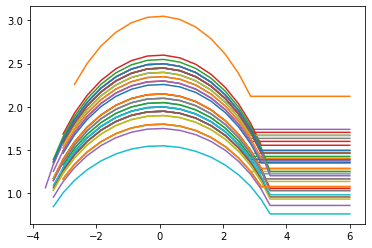

In [270]:
#remove from the front instead! (in the future)


vectors=np.array([])
list_of_lengths=[]
for i in range(len(rows_2d)):
    vector=get_ellipse(rows_2d[i])
    list_of_lengths.append(len(vector))
    vectors=np.append(vectors,vector)
        
        
print(list_of_lengths)
m=min(list_of_lengths)
print(len(vectors))
idx=[]
for count,i in enumerate(list_of_lengths):
    if i!=m:
        idx+=range(count*m , count*m + (i-m))
        

print(idx)    

new_vectors=np.delete(vectors, idx, axis=None).reshape(42,48)


In [272]:
pd.DataFrame(new_vectors)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-2.689204,1.480556,-2.288467,1.640345,-1.850153,1.773199,-1.381460,1.876937,-0.890084,1.949856,...,4.610399,1.391365,4.957799,1.391365,5.305199,1.391365,5.652600,1.391365,6.000000,1.391365
1,-2.689204,2.257848,-2.288467,2.501525,-1.850153,2.704128,-1.381460,2.862329,-0.890084,2.973530,...,4.610399,2.121832,4.957799,2.121832,5.305199,2.121832,5.652600,2.121832,6.000000,2.121832
2,-2.288467,1.763370,-1.850153,1.906189,-1.381460,2.017707,-0.890084,2.096095,-0.384092,2.140065,...,4.758069,1.285938,5.068551,1.285938,5.379034,1.285938,-2.689204,1.591598,-2.288467,1.763370
3,-1.850153,1.906189,-1.381460,2.017707,-0.890084,2.096095,-0.384092,2.140065,0.128206,2.148895,...,5.161758,1.055043,5.441172,1.055043,5.720586,1.055043,6.000000,1.055043,-3.045784,1.620571
4,-2.689204,1.850695,-2.288467,2.050431,-1.850153,2.216498,-1.381460,2.346171,-0.890084,2.437320,...,5.305199,1.739206,5.652600,1.739206,6.000000,1.739206,-3.045784,1.166811,-2.689204,1.332500
5,-2.288467,1.476310,-1.850153,1.595879,-1.381460,1.689243,-0.890084,1.754870,-0.384092,1.791682,...,5.379034,1.076599,5.689517,1.076599,6.000000,1.076599,-3.045784,1.588160,-2.689204,1.813681
6,-2.288467,2.009422,-1.850153,2.172168,-1.381460,2.299248,-0.890084,2.388573,-0.384092,2.438679,...,5.068551,1.465371,5.379034,1.465371,5.689517,1.465371,6.000000,1.465371,-3.045784,1.264045
7,-2.689204,1.443542,-2.288467,1.599336,-1.850153,1.728869,-1.381460,1.830013,-0.890084,1.901109,...,4.957799,1.356581,5.305199,1.356581,5.652600,1.356581,6.000000,1.356581,-3.045784,1.166811
8,-2.689204,1.332500,-2.288467,1.476310,-1.850153,1.595879,-1.381460,1.689243,-0.890084,1.754870,...,4.957799,1.252229,5.305199,1.252229,5.652600,1.252229,6.000000,1.252229,-3.045784,1.361280
9,-2.689204,1.554584,-2.288467,1.722362,-1.850153,1.861859,-1.381460,1.970784,-0.890084,2.047349,...,4.610399,1.460933,4.957799,1.460933,5.305199,1.460933,5.652600,1.460933,6.000000,1.460933


In [273]:
norm_vectors=StandardScaler().fit_transform(new_vectors)

In [275]:
# Check if data is normalized

np.mean(norm_vectors) , np.std(norm_vectors)

(-1.339316664627173e-16, 1.0)

In [277]:
# Check how many components are required to retain 98% variance

pca=PCA(0.98)
pca_v=pca.fit_transform(norm_vectors)
pca.n_components_

16

In [278]:
# Create PCA with 6 components
pca=convers_pca(no_of_components=16)
pca.fit(norm_vectors)

In [12]:
# x = x_m + Pb
# x_m --> mean 
# P   --> t eigenvectors (p1|p2|....|pt)
# b   --> t vectors of weights (b1|b2|....|bt)T ,  -3 sqrt(lambda) < b_i < 3 sqrt(lambda)

x_m=np.array(left_ventricle.mean())


In [288]:
p=pca.projection_matrix.T
pca.eigen_values

array([ 2.02903241e+01+0.00000000e+00j,  1.03440361e+01+0.00000000e+00j,
        7.28703147e+00+0.00000000e+00j,  2.52494299e+00+0.00000000e+00j,
        1.65227732e+00+0.00000000e+00j,  1.37812605e+00+0.00000000e+00j,
        1.05628752e+00+0.00000000e+00j,  7.44950887e-01+0.00000000e+00j,
        6.00515685e-01+0.00000000e+00j,  4.85648890e-01+0.00000000e+00j,
        4.13735466e-01+0.00000000e+00j,  3.90174693e-01+0.00000000e+00j,
        3.28794259e-01+0.00000000e+00j,  3.07797535e-01+0.00000000e+00j,
        2.42703579e-01+0.00000000e+00j,  2.23614657e-01+0.00000000e+00j,
        1.94749713e-01+0.00000000e+00j,  1.57716200e-01+0.00000000e+00j,
        1.08287163e-01+0.00000000e+00j,  9.90577124e-02+0.00000000e+00j,
        7.91502011e-02+0.00000000e+00j,  5.83592481e-02+0.00000000e+00j,
        3.86505583e-02+0.00000000e+00j,  3.78768621e-02+0.00000000e+00j,
        3.30969794e-02+0.00000000e+00j,  2.35958453e-02+0.00000000e+00j,
        1.86992378e-02+0.00000000e+00j,  1.43955082

In [281]:
b=pca.explained_variance
lower_limit=-2*np.sqrt(b)
upper_limit=2*np.sqrt(b)

In [282]:
#adjust 1st mode, set all other paramters to zero

b1_low=np.concatenate((lower_limit[0],np.zeros(5)),axis=None).T
b1_high=np.concatenate((upper_limit[0],np.zeros(5)),axis=None).T
b2_low=np.concatenate((np.zeros(1),lower_limit[1],np.zeros(4)),axis=None).T
b2_high=np.concatenate((np.zeros(1),upper_limit[1],np.zeros(4)),axis=None).T

In [283]:
x1_low=x_m+ np.matmul(p,b1_low)
x1_high=x_m+ np.matmul(p,b1_high)
x2_low=x_m+ np.matmul(p,b2_low)
x2_high=x_m+ np.matmul(p,b2_high)

In [284]:
x1_low

array([4.4472861 +0.j, 4.41995817+0.j, 8.26858222+0.j, 5.05822621+0.j,
       4.43991677+0.j, 4.92779528+0.j, 5.08133744+0.j])

In [108]:
rows_2d[7]

array([0.7 , 1.  , 3.9 , 2.4 , 0.7 , 1.3 , 2.14])

In [100]:
q

array([-2.68920356,  1.48055599, -2.28846664,  1.64034451, -1.85015316,
        1.77319861, -1.38146022,  1.87693684, -0.89008374,  1.94985582,
       -0.3840921 ,  1.99075823,  0.12820631,  1.99897243,  0.63839958,
        1.97436357,  1.13811035,  1.91733571,  1.61913337,  1.82882525,
        2.07357027,  1.71028553,  2.49395921,  1.56366296,  2.8733974 ,
        1.3913651 ,  2.8733974 ,  1.3913651 ,  2.93720562,  1.3913651 ,
        3.00101383,  1.3913651 ,  3.06482205,  1.3913651 ,  3.12863027,
        1.3913651 ,  3.19243848,  1.3913651 ,  3.2562467 ,  1.3913651 ,
        3.32005491,  1.3913651 ,  3.38386313,  1.3913651 ,  3.44767135,
        1.3913651 ,  3.51147956,  1.3913651 ,  3.57528778,  1.3913651 ,
        3.639096  ,  1.3913651 ,  3.70290421,  1.3913651 ,  3.76671243,
        1.3913651 ,  3.83052065,  1.3913651 ,  3.89432886,  1.3913651 ,
        3.95813708,  1.3913651 ,  4.02194529,  1.3913651 ,  4.08575351,
        1.3913651 ,  4.14956173,  1.3913651 ,  4.21336994,  1.39

In [185]:

def draw_shape(a):
    
    septum_d,septum_s=a[0],a[1]
    dim_d,dim_s=a[2],a[3]
    wall_d,wall_s=a[4],a[5]
    
    
    # Estimate shape using  parametric eqn of ellipse
    # x = u + a cos(t) ; y = v + b sin(t)

    u=0     #x-position of the center
    v=0   #y-position of the center
    a=4 #radius on the x-axis
    b=dim_d/2   #radius on the y-axis
    indices=[]

    t_all= np.linspace(0, 2*pi, 100)
    x_all=(u+a*np.cos(t_all))[::-1]
    y_all=(v+b*np.sin(t_all))[::-1]

    #remove x,y coordinates where y< (dim_s/2)

    for i,(x,y) in enumerate(zip(x_all,y_all)):
        if y<=dim_s/2:
            indices+=[i]


    x=np.delete(x_all,indices)
    y=np.delete(y_all,indices)
    
    y_s=y + septum_d
    y_w= -y - wall_d
    
    # Split the ellipse into 2 (left and right)

    ys_left=y_s[:np.argmax(y_s)+1]
    xs_left=x[:np.argmax(y_s)+1]
    yw_left=y_w[:np.argmin(y_w)+1]
    xw_left=xs_left

    ys_right=y_s[np.argmax(y_s):]
    xs_right=x[np.argmax(y_s):]
    yw_right=y_w[np.argmin(y_w):]
    xw_right=xs_right
    
    # Ensure that the right side of the ellipse do not go under the straight line

    indices=np.where(ys_right< (y[-1]+ septum_s))
    indices_1=np.where(yw_right > (-y[-1]-wall_s))

    ys_right = np.delete(ys_right, indices)
    xs_right= np.delete(xs_right, indices)
    yw_right=np.delete(yw_right,indices_1)
    xw_right=np.delete(xw_right,indices_1)
    
    
    # Estimate shape of LVIDs using a horizontal line
    x_more=np.linspace(x[-1],6,100)
    y_more=np.linspace(y[-1],y[-1],100)
    ys_more=np.linspace(y[-1]+ septum_s,y[-1] + septum_s,100)
    yw_more=np.linspace(-y[-1]-wall_s,-y[-1] - wall_s,100)
    xs_more=np.linspace(xs_right[-1],6,100)
    xw_more=np.linspace(xw_right[-1],6,100)
    
    
    # Add all the x,y coordinates respectively

    x=np.concatenate((x,x_more),axis=None)
    y=np.concatenate((y,y_more),axis=None)
    y_s=np.concatenate((ys_left,ys_right,ys_more),axis=None)
    x_s=np.concatenate((xs_left,xs_right,xs_more),axis=None)
    y_w=np.concatenate((yw_left,yw_right,yw_more),axis=None)
    x_w=np.concatenate((xw_left,xw_right,xw_more),axis=None)
    
    
    # Plot the graphs

    #fig, ax = plt.subplots()
    #axes.Axes.set_aspect(ax,aspect=0.5)
    plt.grid(color='lightgray',linestyle='--')
    plt.xlim(-4, 6)
    plt.ylim(-4, 4)
    plt.plot(x,y)
    plt.plot(x,-y)
    plt.plot(x_s,y_s)
    plt.plot(x_w,y_w)
    plt.show()
    
    print(len(x))
    

In [186]:
vectors=np.array([])
for i in range(10):
    vector=draw_shape(rows_2d[i])

126
127
131
135
128
131
130
129
129
128
